When you run this code, **SKIP THE FIRST WHOLE SECTION**

The second section creates the covariate matrix and response vector that we need for linear regression and later logistic regression

The third section performs the linear regression for batch 1

In [1]:
import numpy as np
import pandas as pd
from collections import Counter
from collections import defaultdict


In [2]:
from src.data import embed

# Testing (skip this whole section)

### Test embedding matrices (skip)

In [21]:
# Example setup: Generate a mock input matrix
# Rows: [one-hot encoding (4 rows for A, T, G, C), CNV loss, CNV gain, open chromatin]
# Columns: Nucleotide positions (e.g., 6000 columns for 6k bp)
np.random.seed(42)  # For reproducibility
n_positions = 6000
mock_matrix = np.random.randint(0, 2, size=(7, n_positions))

In [22]:
print(mock_matrix.shape) # a random matrix of 0 and 1
print(mock_matrix)

(7, 6000)
[[0 1 0 ... 1 1 1]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 1 1 1]
 ...
 [1 1 0 ... 1 1 0]
 [1 1 0 ... 1 1 1]
 [1 1 0 ... 0 1 0]]


In [23]:
mock_matrix1 = np.zeros((7, 6000))
mock_matrix1[1, :] = np.ones(6000)
mock_matrix1[-1, :] = 3* np.ones(6000)
mock_matrix1[-2, :] = 4* np.ones(6000)
mock_matrix1[-3, :] = 5* np.ones(6000)
mock_matrix1

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 1., 1., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [5., 5., 5., ..., 5., 5., 5.],
       [4., 4., 4., ..., 4., 4., 4.],
       [3., 3., 3., ..., 3., 3., 3.]])

### Agregation function

In [32]:
def aggregate_matrix(matrix, tss_position=2000):
    """
    Create a dataset that combines codon frequencies and aggregated CNV/open chromatin metrics.

    Args:
        matrix (numpy.ndarray): The embedding matrix.
        tss_position (int): The starting position for codon counting (default is 1).

    Returns:
        numpy.ndarray: A 1-row dataset with 64 columns for codon counts and 3 columns for CNV/open chromatin metrics.
    """
    # Extract one-hot DNA rows (first 4 rows: A, T, G, C)
    nucleotides = ['A', 'T', 'G', 'C']
    one_hot_dna = matrix[:4, :]

    # Decode one-hot to nucleotide sequence
    sequence = ''.join(
        nucleotides[np.argmax(one_hot_dna[:, i])]
        for i in range(one_hot_dna.shape[1])
    )

    # Start codon counting from the TSS
    start = tss_position - 1
    codons = [
        sequence[i:i + 3]
        for i in range(start, len(sequence), 3)
        if i + 3 <= len(sequence)
    ]

    # Generate all 64 possible codons
    possible_codons = [a + b + c for a in nucleotides for b in nucleotides for c in nucleotides]

    # Count codon frequencies
    codon_counts = Counter(codons)

    # Ensure all 64 codons are represented in the output (with count 0 if absent)
    codon_counts_array = np.array([codon_counts.get(codon, 0) for codon in possible_codons])

    # Extract CNV and open chromatin rows (last 3 rows)
    cnv_loss = matrix[4, :] #TODO do we take the average across all embedding or also from TSS??
    cnv_gain = matrix[5, :]
    open_chromatin = matrix[6, :]

    # Compute averages
    cnv_loss_avg = np.mean(cnv_loss)
    cnv_gain_avg = np.mean(cnv_gain)
    open_chromatin_avg = np.mean(open_chromatin)

    # Combine codon frequencies and aggregated metrics into one dataset
    aggregated_values = np.array([cnv_loss_avg, cnv_gain_avg, open_chromatin_avg])
    final_dataset = np.concatenate([codon_counts_array, aggregated_values])

    # Create column headings
    codon_headings = possible_codons
    aggregated_headings = ['cnv_loss_avg', 'cnv_gain_avg', 'open_chromatin_avg']
    column_headings = codon_headings + aggregated_headings

    return final_dataset, column_headings


In [ ]:
def aggregate_matrix_fast(matrix, tss_position=2000):
    """
    Create a dataset that combines codon frequencies and aggregated CNV/open chromatin metrics.
    
    Args:
        matrix (numpy.ndarray): The embedding matrix.
        tss_position (int): The starting position for codon counting (default is 2000).
    
    Returns:
        numpy.ndarray: A 1-row dataset with 64 columns for codon counts and 3 columns for CNV/open chromatin metrics.
    """
    nucleotides = np.array(['A', 'T', 'G', 'C'])
    
    # Extract one-hot DNA rows and decode to sequence efficiently
    sequence = nucleotides[np.argmax(matrix[:4, :], axis=0)]
    
    # Compute valid codon start positions
    start = tss_position - 1
    sequence_length = len(sequence)
    
    # Use NumPy slicing for codon extraction
    valid_indices = np.arange(start, sequence_length - 2, 3)
    codons = np.char.add(np.char.add(sequence[valid_indices], sequence[valid_indices + 1]), sequence[valid_indices + 2])
    
    # Generate all possible codons
    possible_codons = np.array([a + b + c for a in nucleotides for b in nucleotides for c in nucleotides])
    
    # Count occurrences using np.unique
    unique_codons, counts = np.unique(codons, return_counts=True)
    codon_counts = dict(zip(unique_codons, counts))
    
    # Create a codon frequency array
    codon_counts_array = np.array([codon_counts.get(codon, 0) for codon in possible_codons], dtype=int)

    # Normalize counts
    total = np.sum(codon_counts_array)
    if total != 0: # Avoid division by 0
        codon_counts_array = codon_counts_array / total  # Normalize
    
    # Extract CNV and open chromatin rows
    cnv_loss = matrix[4, :]
    cnv_gain = matrix[5, :]
    open_chromatin = matrix[6, :]
    
    # Compute averages
    cnv_loss_avg = np.mean(cnv_loss)
    cnv_gain_avg = np.mean(cnv_gain)
    open_chromatin_avg = np.mean(open_chromatin)
    
    # Combine features
    aggregated_values = np.array([cnv_loss_avg, cnv_gain_avg, open_chromatin_avg])
    final_dataset = np.concatenate([codon_counts_array, aggregated_values])
    
    # Column names
    codon_headings = possible_codons.tolist()
    aggregated_headings = ['cnv_loss_avg', 'cnv_gain_avg', 'open_chromatin_avg']
    column_headings = codon_headings + aggregated_headings
    
    return final_dataset, column_headings


### Tests for aggregate matrix (skip)

In [29]:
final_dataset, column_headings = aggregate_matrix_fast(mock_matrix)
print(final_dataset)
print(column_headings)

[0.18379595 0.07126782 0.04876219 0.01650413 0.07951988 0.03975994
 0.024006   0.01350338 0.03675919 0.01350338 0.00825206 0.00450113
 0.01500375 0.00975244 0.00525131 0.         0.07351838 0.03450863
 0.01350338 0.01050263 0.04126032 0.01425356 0.00375094 0.0060015
 0.01650413 0.01125281 0.00225056 0.00075019 0.01050263 0.00450113
 0.00150038 0.00150038 0.03900975 0.01425356 0.00750188 0.00900225
 0.01050263 0.0060015  0.00450113 0.         0.00900225 0.00375094
 0.00075019 0.00075019 0.00300075 0.00075019 0.         0.00075019
 0.01950488 0.00825206 0.00375094 0.00450113 0.00975244 0.00525131
 0.00150038 0.         0.00750188 0.00825206 0.00150038 0.00150038
 0.00150038 0.00150038 0.         0.         0.5015     0.50916667
 0.49933333]
['AAA', 'AAT', 'AAG', 'AAC', 'ATA', 'ATT', 'ATG', 'ATC', 'AGA', 'AGT', 'AGG', 'AGC', 'ACA', 'ACT', 'ACG', 'ACC', 'TAA', 'TAT', 'TAG', 'TAC', 'TTA', 'TTT', 'TTG', 'TTC', 'TGA', 'TGT', 'TGG', 'TGC', 'TCA', 'TCT', 'TCG', 'TCC', 'GAA', 'GAT', 'GAG', 'GAC'

In [34]:
final_dataset, column_headings = aggregate_matrix_fast(mock_matrix1)
print(final_dataset)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 5. 4. 3.]


### Load data: gene positions and classification

Import dataset of gene positions (ignore)

Import classification dataset

In [19]:
class_path = 'data/splits/batch1_test_filtered.tsv'
classification_df = pd.read_csv(class_path, sep="\t")
classification_df

,barcode,gene_id,expression_count,classification
0,AAACCGAAGGCGCATC-1,ENSG00000269113,0.825470,low
1,AAACCGAAGGCGCATC-1,ENSG00000231252,0.495597,low
2,AAACCGAAGGCGCATC-1,ENSG00000188641,0.495597,low
3,AAACCGAAGGCGCATC-1,ENSG00000265972,1.271419,high
4,AAACCGAAGGCGCATC-1,ENSG00000197956,0.495597,low
...,...,...,...,...
18630,TTTAGGATCGTTATCT-1,ENSG00000198938,1.444938,high
18631,TTTAGGATCGTTATCT-1,ENSG00000198840,1.768557,high
18632,TTTAGGATCGTTATCT-1,ENSG00000198886,0.963478,high
18633,TTTAGGATCGTTATCT-1,ENSG00000198786,0.963478,high


In [11]:
import pandas as pd
from collections import defaultdict


# Initialize dictionary
barcode_dict = defaultdict(list)

# Populate dictionary
for barcode, gene_id in zip(classification_df.iloc[:, 0], classification_df.iloc[:, 1]):
    barcode_dict[barcode].append(gene_id)

# Convert defaultdict to a regular dictionary
barcode_dict = dict(barcode_dict)


In [15]:
gene_ids = classification_df[classification_df.iloc[:, 0] == 'TTTGTTGGTGGCTTCC-1'].iloc[:, 1]
print(gene_ids)

347621    ENSG00000269113
347622    ENSG00000188641
347623    ENSG00000265972
347624    ENSG00000231424
347625    ENSG00000196352
               ...       
347719    ENSG00000129682
347720    ENSG00000198712
347721    ENSG00000198899
347722    ENSG00000198786
347723    ENSG00000198727
Name: gene_id, Length: 103, dtype: object


In [13]:
barcode_dict['TTTGTTGGTGGCTTCC-1']

['ENSG00000269113',
 'ENSG00000188641',
 'ENSG00000265972',
 'ENSG00000231424',
 'ENSG00000196352',
 'ENSG00000172554',
 'ENSG00000115738',
 'ENSG00000055813',
 'ENSG00000071073',
 'ENSG00000153208',
 'ENSG00000231969',
 'ENSG00000157827',
 'ENSG00000162989',
 'ENSG00000144290',
 'ENSG00000236283',
 'ENSG00000081479',
 'ENSG00000115896',
 'ENSG00000231304',
 'ENSG00000170293',
 'ENSG00000241684',
 'ENSG00000269028',
 'ENSG00000144847',
 'ENSG00000069849',
 'ENSG00000085276',
 'ENSG00000229102',
 'ENSG00000272620',
 'ENSG00000249631',
 'ENSG00000248049',
 'ENSG00000138744',
 'ENSG00000138756',
 'ENSG00000163297',
 'ENSG00000145284',
 'ENSG00000138639',
 'ENSG00000118785',
 'ENSG00000184305',
 'ENSG00000287292',
 'ENSG00000145416',
 'ENSG00000151726',
 'ENSG00000145536',
 'ENSG00000112902',
 'ENSG00000145687',
 'ENSG00000172348',
 'ENSG00000164418',
 'ENSG00000111885',
 'ENSG00000164674',
 'ENSG00000197461',
 'ENSG00000106415',
 'ENSG00000048052',
 'ENSG00000158321',
 'ENSG00000235139',


In [36]:
classification_lookup = classification_df.set_index(['gene_id', 'barcode'])[['expression_count', 'classification']].to_dict(orient='index')
classification_lookup

{('ENSG00000269113', 'AAACAGCCACAATACT-1'): {'expression_count': 1.5382726,
  'classification': 'high'},
 ('ENSG00000172260', 'AAACAGCCACAATACT-1'): {'expression_count': 0.7969874,
  'classification': 'low'},
 ('ENSG00000188641', 'AAACAGCCACAATACT-1'): {'expression_count': 0.7969874,
  'classification': 'low'},
 ('ENSG00000265972', 'AAACAGCCACAATACT-1'): {'expression_count': 0.7969874,
  'classification': 'low'},
 ('ENSG00000230426', 'AAACAGCCACAATACT-1'): {'expression_count': 1.5382726,
  'classification': 'high'},
 ('ENSG00000266028', 'AAACAGCCACAATACT-1'): {'expression_count': 0.7969874,
  'classification': 'low'},
 ('ENSG00000163219', 'AAACAGCCACAATACT-1'): {'expression_count': 0.7969874,
  'classification': 'low'},
 ('ENSG00000071073', 'AAACAGCCACAATACT-1'): {'expression_count': 1.2348006,
  'classification': 'high'},
 ('ENSG00000162989', 'AAACAGCCACAATACT-1'): {'expression_count': 0.7969874,
  'classification': 'low'},
 ('ENSG00000236283', 'AAACAGCCACAATACT-1'): {'expression_coun

Sets of genes and cells that were preprocessed

In [20]:
barcode_set = set(classification_df['barcode'])
gene_set = set(classification_df['gene_id'])

In [39]:
len(barcode_set)

13677

We have to make sure that the barcodes are also in the epiAneufinder file

In [5]:
cnv_path = 'preprocessing/Multiome/epiAneufinder.tsv'
epiAneu_df = pd.read_csv(cnv_path, sep='\t')

In [7]:
column_names_str = str(epiAneu_df.columns.to_list()[0])
column_names_list = column_names_str.split(' ')
column_names_list = column_names_list[4:]
cleaned_list = [item.lstrip("cell-") for item in column_names_list]

In [8]:
filtered_class_df = classification_df[classification_df["barcode"].isin(cleaned_list)]
filtered_class_df

,barcode,gene_id,expression_count,classification
423,AAACCGAAGGCGCATC-1,ENSG00000269113,0.825470,low
424,AAACCGAAGGCGCATC-1,ENSG00000231252,0.495597,low
425,AAACCGAAGGCGCATC-1,ENSG00000188641,0.495597,low
426,AAACCGAAGGCGCATC-1,ENSG00000265972,1.271419,high
427,AAACCGAAGGCGCATC-1,ENSG00000197956,0.495597,low
...,...,...,...,...
347616,TTTGTTGGTGCCGCAA-1,ENSG00000198938,2.220852,high
347617,TTTGTTGGTGCCGCAA-1,ENSG00000198840,1.968703,high
347618,TTTGTTGGTGCCGCAA-1,ENSG00000198886,1.116385,high
347619,TTTGTTGGTGCCGCAA-1,ENSG00000198786,1.406267,high


In [8]:
column_names_list1 = []
for cell in column_names_list:
    column_names_list1.append(cell.strip('cell-'))

print(column_names_list1)

['GCGCAATGTTGCGGAT-3', 'CTAGTGAGTCACCTAT-3', 'AATCATGTCGATCAGT-1', 'TCCTTAGTCGGGACTC-4', 'ACTATCCGTCTAACCT-1', 'GTGCACGGTCACAAAT-3', 'TACGTAATCGTTTCGC-3', 'ATTGGTTCACATTGCA-1', 'TACCTCATCGAAGTAG-2', 'GTCTTGCTCCTGTTCA-4', 'TAGCGGCTCAATGTGC-1', 'CCGTTATGTTAGCCAA-2', 'GTGCTCAAGGTTACAC-3', 'TTAAGGACATCGCTTT-3', 'CTAAGTCAGTTGGCCA-3', 'GCAGGTGAGCGAGCGA-3', 'ATCACAATCGCCTGTT-2', 'TGAGGAGGTAAACAAG-3', 'AATCCCTGTACCGAAC-4', 'GAGTTGCGTCAATACG-3', 'CTTGTTCCACAATTAC-4', 'ATCGAGGCAGAAACGT-2', 'TCGTTAAAGCCGCAGT-1', 'CGGTGAGAGCATTAGC-1', 'AAGCAAGTCCAGCACA-4', 'CTGCAATAGACAACAG-2', 'GGATGTAAGGGATGAC-3', 'GTCCAGGGTATACTGG-3', 'CTTTGGGAGTTGCGTG-4', 'TTAGACTCAGCTAATT-4', 'GGAGTCTGTCGCGCAA-4', 'TAGCAGGCAAGGTAAC-2', 'CTAATGTCAATTTGGT-4', 'ACGAAGTCAGACAAAC-1', 'TTCATTCAGTGCTGTG-4', 'AAGGTGCAGCCTGACA-3', 'TCCTCACAGTCATTAG-3', 'TCCTTGCAGGAAGCTA-3', 'TTGCAAGGTAATCGTG-3', 'ATCAGGTTCATTTGTC-2', 'CTCTTGATCCTTGAGG-4', 'AGTCAAGAGTGTTGCG-2', 'CTTACCTCATCCATCT-3', 'AGCAAATAGCCTGGTA-4', 'CACCTCAGTAATTAGC-3', 'CGGCTAAT

In [15]:
# Filter the set to keep only elements also in the list
barcode_set_filtered = barcode_set.intersection(column_names_list1)
barcode_set_filtered

{'GTAGGCGAGCATGTCG-1',
 'CACAAGCGTACCTTAC-3',
 'CCGCTAGCAACAGCCT-4',
 'TGCATCCTCCCTCAAC-4',
 'GGACATAAGCGAAGTA-4',
 'CGGTTATAGGAGTCGG-3',
 'GTTCTTGTCCCGCATT-3',
 'GATCGAGCATTGCAGC-3',
 'CGGTTATAGTTGTCCC-3',
 'TTGTAAGTCATTGACA-4',
 'TCAGTGAGTACGGTAC-3',
 'GTAGTTTCAACAGGTG-4',
 'CTTGTAAAGGAAGCTA-1',
 'GCCCATAAGGAGGTTA-4',
 'AGCACTTAGTAAACCC-3',
 'TACGCTTGTCTAACAG-3',
 'TGGACCGGTAGCTAGC-4',
 'GCCTACTTCAATGTGC-4',
 'TTCAACCGTCAATACG-2',
 'TGAGCACGTCTTGCAT-1',
 'AGCGGACCATTGGGAG-4',
 'GGACGAAGTCATGAGC-4',
 'GGTCAATTCCCTTGCG-3',
 'TCGTAATCATTGTGAT-4',
 'TGAGGAGGTACCGAAC-1',
 'CCCAAACCACTGGCTG-3',
 'AGAGAGGAGAGAAGGG-3',
 'CGATATTCACGAATCC-4',
 'CAGCTCAAGGAGCAAC-4',
 'CAATGTGGTCCTTTAA-4',
 'TGTTATGAGCACGATT-4',
 'AAATCCGGTCCTAATC-3',
 'TAGCTTAAGCCATCAG-4',
 'GGATGGCCACCATATG-4',
 'CTGGTCAAGAATCTCA-4',
 'GGTTGAGCAAGCCAGA-1',
 'CAGCAAGCATAATTGC-1',
 'TTGCTTTAGTACTGGT-3',
 'GCTCCTTAGGGCTTAT-1',
 'CTTAGTTTCGCAATCG-2',
 'TTTGTTGGTTGAGGTC-3',
 'GCTAAGAAGACTAAGG-1',
 'CGGTTGGGTTAGCGTA-4',
 'TAGGTTGGT

In [5]:
def adjust_barcode_names_for_embedding(barcode_set):
    output_set = set()
    barcode_list = list(barcode_set)
    for b in barcode_list:
        b_string = str(b)
        output_set.add('cell-' + b_string)

    return output_set

In [6]:
def create_input_sets(classification_df, epiAneu_df):

    # Set of barcode and genes from classification df
    barcode_set = set(classification_df['barcode'])
    gene_set = set(classification_df['gene_id'])

    # Fix names of barcodes in the set
    barcode_set = adjust_barcode_names_for_embedding(barcode_set)
    
    # List of barcodes in epiAneufinder
    column_names_str = str(epiAneu_df.columns.to_list()[0])
    column_names_list = column_names_str.split(' ')
    column_names_list = column_names_list[4:]

    # Filter the set to keep only elements also in the list
    barcode_set_filtered = barcode_set.intersection(column_names_list)
    barcode_set_filtered

    return barcode_set_filtered, gene_set

In [29]:
barcode_set_filtered, gene_set =create_input_sets(classification_df, epiAneu_df)

In [30]:
print(barcode_set_filtered)
print(len(barcode_set_filtered))
print(gene_set)
print(len(gene_set))

{'cell-AATTACCCAGCAAGTG-1', 'cell-CGTTAGGTCGAGGAGT-1', 'cell-AGTTGCGTCGATATTG-1', 'cell-CTGTTAAAGGTTACGT-1', 'cell-CTATTCAGTGGTGAGA-1', 'cell-CGGTGAGAGCATTAGC-1', 'cell-TCCATTGTCTATGACA-1', 'cell-CCGTTACTCGTAACGT-1', 'cell-GAAGGAACAGGTTCAC-1', 'cell-ACCTACCTCGGCTAGC-1', 'cell-ACCCTGTTCATAGCCG-1', 'cell-ACTATCCGTTTAACGG-1', 'cell-CACCGGTAGTCCTTCA-1', 'cell-GCTAAGTTCGGGCCAT-1', 'cell-GTATGTTCATAAAGCA-1', 'cell-CATTATCTCGCGACAC-1', 'cell-ACCTTCCAGTAGCTTA-1', 'cell-AGCCAGTGTGCTTAGA-1', 'cell-TGATGAACAAGGCCAA-1', 'cell-CATCCTCAGGAGCAAC-1', 'cell-GTAATAGCAACTAGGG-1', 'cell-AGCCGCTAGAATGACG-1', 'cell-ATCACACAGTTTCCGC-1', 'cell-CAACAATGTCAACAAT-1', 'cell-GGATGAATCCTGATTT-1', 'cell-TGAACAGAGCACTTGG-1', 'cell-CTATGGCCAGACAAAC-1', 'cell-GCCTTTATCTAATTGG-1', 'cell-TGGACCGGTGTGCAAC-1', 'cell-ACACTAATCCGTTAAA-1', 'cell-GCATATATCGTTTCTG-1', 'cell-GGACCGAAGCGATAAG-1', 'cell-TGTGTTAAGAGAAGGG-1', 'cell-GTGCACGGTGTCCAAA-1', 'cell-GTTACCTGTTAGGCTA-1', 'cell-GTGCGGTTCTCGACCT-1', 'cell-AACAGATAGGTCAAAG-1', 

### Test data (skip)

In [35]:
#Last 100 elements of the dataset
class_df_test = classification_df.iloc[27353895:27353995]
barcode_set_testing = set(class_df_test['barcode'])
genes_set_testing = set(class_df_test['gene_id'])
print(barcode_set_testing)
print(genes_set_testing)

{'TTTGTTGGTTGAGGTC-3'}
{'ENSG00000241743', 'ENSG00000198712', 'ENSG00000226679', 'ENSG00000011201', 'ENSG00000102271', 'ENSG00000278847', 'ENSG00000068366', 'ENSG00000236091', 'ENSG00000078596', 'ENSG00000101846', 'ENSG00000156298', 'ENSG00000100311', 'ENSG00000165583', 'ENSG00000283697', 'ENSG00000234688', 'ENSG00000286326', 'ENSG00000230668', 'ENSG00000147113', 'ENSG00000160219', 'ENSG00000077279', 'ENSG00000225689', 'ENSG00000182162', 'ENSG00000280870', 'ENSG00000012817', 'ENSG00000212907', 'ENSG00000188511', 'ENSG00000260683', 'ENSG00000169306', 'ENSG00000286050', 'ENSG00000198763', 'ENSG00000227042', 'ENSG00000198804', 'ENSG00000013619', 'ENSG00000227610', 'ENSG00000233103', 'ENSG00000100362', 'ENSG00000183878', 'ENSG00000198888', 'ENSG00000147010', 'ENSG00000100336', 'ENSG00000198947', 'ENSG00000089472', 'ENSG00000235111', 'ENSG00000189108', 'ENSG00000099725', 'ENSG00000286381', 'ENSG00000129824', 'ENSG00000176728', 'ENSG00000228253', 'ENSG00000228343', 'ENSG00000231535', 'ENSG00

### Create a merged dataset (skip)

Match the datasets by the gene_ids

In [9]:
# Merge the datasets based on the gene_id column
merged_df = pd.merge(
    classification_df, gene_df,
    on="gene_id",  # Match rows based on this column
    how="inner"    # Keep only rows with matches in both datasets
)

# Display the result
print(merged_df)

                     barcode          gene_id  expression_count  \
0         AAACAGCCAAACGCGA-2  ENSG00000235146          0.000000   
1         AAACAGCCAAACGCGA-2  ENSG00000187634          0.240150   
2         AAACAGCCAAACGCGA-2  ENSG00000187583          0.000000   
3         AAACAGCCAAACGCGA-2  ENSG00000205231          0.000000   
4         AAACAGCCAAACGCGA-2  ENSG00000228750          0.000000   
...                      ...              ...               ...   
26697499  TTTGTTGGTTGAGGTC-3  ENSG00000212907          1.068847   
26697500  TTTGTTGGTTGAGGTC-3  ENSG00000198886          1.907476   
26697501  TTTGTTGGTTGAGGTC-3  ENSG00000198786          1.573612   
26697502  TTTGTTGGTTGAGGTC-3  ENSG00000198727          3.001725   
26697503  TTTGTTGGTTGAGGTC-3  ENSG00000273554          0.000000   

         classification    start      end  
0                  zero   587577   595116  
1                   low   923923   944575  
2                  zero   966482   975865  
3                  

For testing we use first 1000 rows

In [10]:
merged_df_testing = merged_df.head(0)
barcode_set_testing = set(merged_df_testing['barcode'])
genes_set_testing = set(merged_df_testing['gene_id'])
print(barcode_set_testing)

{'AAACAGCCAAACGCGA-2'}


### Import the embedding

We get the embedding matrix as an input with following rows:
- 4 rows for one-hot-encoding
- CNV loss
- CNV gain
-open chromatin

In [21]:
# Add your own path
fasta_path = 'data/reference/GRCh38.d1.vd1.fa'
atac_path = 'data/overlap_genes_peaks.tsv' 
cnv_path = 'out/epiAneufinder/epiAneuFinder_results.tsv'

In [29]:
embedder = embed(
	fasta_path,
	atac_path,
	cnv_path,
	gene_set=gene_set,
	barcode_set=barcode_set,
	mode='single_gene_barcode'
)

[embed]: Computing embeddings (# genes done):   0%|                                            | 0/1024 [06:29<?, ?it/s]


In [26]:
_, _, matrix = next(embedder)
print(np.array(matrix).shape)

(7, 10000)


In [28]:
len(matrix[4, :])


10000

In [30]:
list_mean_loss = []
for barcode, gene, matrix in embedder:
    row_loss = matrix[4, :]
    list_mean_loss.append(np.mean(row_loss))

[embed]: Iterating over all possible barcode-gene combinations
[embed]: Computing Embeddings with mode: "single_gene_barcode"
[embed]: Using 102 barcodes
[embed]: Using 1024 genes


[embed]: Computing embeddings (# genes done): 100%|█████████████████████████████████| 1024/1024 [05:29<00:00,  3.11it/s]


In [32]:
# Get unique values in the selected column
unique_values = np.unique(list_mean_loss)

# Count of unique values
num_unique_values = unique_values.size

print("Unique values:", unique_values)
print("Number of unique values:", num_unique_values)

Unique values: [0.]
Number of unique values: 1


# Create the covariate matrix and the response vector

We will have a **matrix X** that has per pair (cell_barcode, gene_id) a row of 67 inputs: 64 are the counts of the triplets and 3 are the averages of open cromatine, cnv gain, cnv loss over the nucleotides

There will be 2 **response vectors**:
- y1: has expression counts per pair (cell_barcode, gene_id)
- y2: classification of expression per pair (cell_barcode, gene_id)

Slow function: for 1 barcode and 100 genes it neads 5min

In [35]:
def aggregate_matrix_fast(matrix, tss_position=2000):
    """
    Create a dataset that combines codon frequencies and aggregated CNV/open chromatin metrics.
    
    Args:
        matrix (numpy.ndarray): The embedding matrix.
        tss_position (int): The starting position for codon counting (default is 2000).
    
    Returns:
        numpy.ndarray: A 1-row dataset with 64 columns for codon counts and 3 columns for CNV/open chromatin metrics.
    """
    nucleotides = np.array(['A', 'T', 'G', 'C'])
    
    # Extract one-hot DNA rows and decode to sequence efficiently
    sequence = nucleotides[np.argmax(matrix[:4, :], axis=0)]
    
    # Compute valid codon start positions
    start = tss_position - 1
    sequence_length = len(sequence)
    
    # Use NumPy slicing for codon extraction
    valid_indices = np.arange(start, sequence_length - 2, 3)
    codons = np.char.add(np.char.add(sequence[valid_indices], sequence[valid_indices + 1]), sequence[valid_indices + 2])
    
    # Generate all possible codons
    possible_codons = np.array([a + b + c for a in nucleotides for b in nucleotides for c in nucleotides])
    
    # Count occurrences using np.unique
    unique_codons, counts = np.unique(codons, return_counts=True)
    codon_counts = dict(zip(unique_codons, counts))
    
    # Create a codon frequency array
    codon_counts_array = np.array([codon_counts.get(codon, 0) for codon in possible_codons], dtype=int)

    # Normalize counts
    total = np.sum(codon_counts_array)
    if total != 0: # Avoid division by 0
        codon_counts_array = codon_counts_array / total  # Normalize
    
    # Extract CNV and open chromatin rows
    cnv_loss = matrix[4, :]
    cnv_gain = matrix[5, :]
    open_chromatin = matrix[6, :]
    
    # Compute averages
    cnv_loss_avg = np.mean(cnv_loss)
    cnv_gain_avg = np.mean(cnv_gain)
    open_chromatin_avg = np.mean(open_chromatin)
    
    # Combine features
    aggregated_values = np.array([cnv_loss_avg, cnv_gain_avg, open_chromatin_avg])
    final_dataset = np.concatenate([codon_counts_array, aggregated_values])
    
    # Column names
    codon_headings = possible_codons.tolist()
    aggregated_headings = ['cnv_loss_avg', 'cnv_gain_avg', 'open_chromatin_avg']
    column_headings = codon_headings + aggregated_headings
    
    return final_dataset, column_headings

In [4]:
def adjust_barcode_names_for_embedding(barcode_set):
    output_set = set()
    barcode_list = list(barcode_set)
    for b in barcode_list:
        b_string = str(b)
        output_set.add('cell-' + b_string)

    return output_set

In [5]:
def create_input_sets(classification_df, epiAneu_df):

    # Set of barcode and genes from classification df
    barcode_set = set(classification_df['barcode'])
    gene_set = set(classification_df['gene_id'])

    # Fix names of barcodes in the set
    barcode_set = adjust_barcode_names_for_embedding(barcode_set)
    
    # List of barcodes in epiAneufinder
    column_names_str = str(epiAneu_df.columns.to_list()[0])
    column_names_list = column_names_str.split(' ')
    column_names_list = column_names_list[4:]

    # Filter the set to keep only elements also in the list
    barcode_set_filtered = barcode_set.intersection(column_names_list)
    barcode_set_filtered

    return barcode_set_filtered, gene_set

In [45]:
def create_matrix_X_from_embedding(class_path, fasta_path, atac_path, cnv_path):

    # dataset that contains classification
    classification_df = pd.read_csv(class_path, sep="\t")

    # Create a lookup dictionary for expression_count and classification
    classification_lookup = classification_df.set_index(['gene_id', 'barcode'])[['expression_count', 'classification']].to_dict(orient='index')

    # Set of barcode and genes from classification df
    barcode_set = set(classification_df['barcode'])
    gene_set = set(classification_df['gene_id'])
    print('Sets created')
    print(f'Len of barcode set {len(barcode_set)}')

    # call the embed function
    embedder = embed(
        fasta_path,
        atac_path,
        cnv_path,
        gene_set=gene_set,
        barcode_set=barcode_set,
        mode='single_gene_barcode'
    )
    print('Embedder defined')

    X_output = []
    y1 = []
    y2 = []
    row_headings = []

    for barcode, gene_id, embed_matrix in embedder:


        if (gene_id, barcode) in classification_lookup:

            # Directly access the row using MultiIndex
            row_class = classification_lookup[(gene_id, barcode)]
            
            expression = row_class['expression_count']
            classification = row_class['classification']
                

            X_row, _ = aggregate_matrix_fast(embed_matrix)

            X_output.append(X_row)
            y1.append(expression)
            y2.append(classification)
            row_headings.append((barcode, gene_id))


        else:
            pass

    return X_output, y1, y2, row_headings

In [ ]:
def create_matrix_X_from_embedding_dict(class_path, fasta_path, atac_path, cnv_path):

    # Dataset that contains classification
    classification_df = pd.read_csv(class_path, sep="\t")

    # epiAneuf dataset
    epiAneu_df = pd.read_csv(cnv_path, sep='\t')

    # List of barcodes in epiAneufinder
    barcode_str = str(epiAneu_df.columns.to_list()[0])
    barcode_list = barcode_str.split(' ')
    barcode_list = barcode_list[3:]

    # Remove 'cell-' from each string
    cleaned_list = [barcode.replace("cell-", "") for barcode in barcode_list]

    # Create a dictionary with keys: barcodes, values:gene_ids
    barcode_dict = defaultdict(list) # initialize dictionary
    for barcode, gene_id in zip(classification_df.iloc[:, 0], classification_df.iloc[:, 1]): # populate dictionary
        barcode_dict[barcode].append(gene_id)

    # Convert defaultdict to a regular dictionary
    barcode_dict = dict(barcode_dict)

    # Filter the dictionary to keep only keys in barcodes_to_keep
    filtered_barcode_dict = {barcode: gene_ids for barcode, gene_ids in barcode_dict.items() if barcode in cleaned_list}

    # Call the embed function
    embedder = embed(
        fasta_path,
        atac_path,
        cnv_path,
        barcode_to_genes = barcode_dict,
        mode='single_gene_barcode'
    )
    print('Embedder defined')

    X_output = []
    #y1 = []
    #y2 = []

    # Iterate over the embedder
    for barcode, gene_id, embed_matrix in embedder:

        print(barcode)
        print(gene_id)

        # Directly access the row using MultiIndex
        #row_class = classification_lookup[(gene_id, barcode_strip)]
        
        #expression = row_class['expression_count']
        #classification = row_class['classification']
            
        
        # Access the row corresponding to (gene_id, barcodes)
        #row_class = classification_df.loc[(classification_df["gene_id"] == gene_id) & (classification_df["barcode"] == barcode_strip)]

        #expression = row_class['expression_count'].iloc[0]
        #classification = row_class['classification'].iloc[0]

        X_row, _ = aggregate_matrix_fast(embed_matrix)

        X_output.append(X_row)
        #y1.append(expression)
        #y2.append(classification)

        #print(f'Length of matrix X: {len(X_output)}')

    return X_output

The data:
- fasta is the .fa file
- atac is the .tsv file of overlap_genes_peaks
- cnv is the epiAneufinder file

In [14]:
# Add your own path
fasta_path = 'data/reference/GRCh38.d1.vd1.fa'
atac_path = 'data/overlap_genes_peaks.tsv' 
cnv_path = 'out/epiAneufinder/epiAneuFinder_results.tsv'

### Trying to use embedding with dict

In [7]:
# Dataset that contains classification
classification_df = pd.read_csv('data/splits/batch1_test_filtered.tsv', sep="\t")
# epiAneuf dataset
epiAneu_df = pd.read_csv(cnv_path, sep='\t')

In [8]:
# List of barcodes in epiAneufinder
barcode_str = str(epiAneu_df.columns.to_list()[0])
barcode_list = barcode_str.split(' ')
barcode_list = barcode_list[4:]
# Remove 'cell-' from each string
cleaned_list = [barcode.replace("cell-", "") for barcode in barcode_list]
cleaned_list

['GCGCAATGTTGCGGAT-3',
 'CTAGTGAGTCACCTAT-3',
 'AATCATGTCGATCAGT-1',
 'TCCTTAGTCGGGACTC-4',
 'ACTATCCGTCTAACCT-1',
 'GTGCACGGTCACAAAT-3',
 'TACGTAATCGTTTCGC-3',
 'ATTGGTTCACATTGCA-1',
 'TACCTCATCGAAGTAG-2',
 'GTCTTGCTCCTGTTCA-4',
 'TAGCGGCTCAATGTGC-1',
 'CCGTTATGTTAGCCAA-2',
 'GTGCTCAAGGTTACAC-3',
 'TTAAGGACATCGCTTT-3',
 'CTAAGTCAGTTGGCCA-3',
 'GCAGGTGAGCGAGCGA-3',
 'ATCACAATCGCCTGTT-2',
 'TGAGGAGGTAAACAAG-3',
 'AATCCCTGTACCGAAC-4',
 'GAGTTGCGTCAATACG-3',
 'CTTGTTCCACAATTAC-4',
 'ATCGAGGCAGAAACGT-2',
 'TCGTTAAAGCCGCAGT-1',
 'CGGTGAGAGCATTAGC-1',
 'AAGCAAGTCCAGCACA-4',
 'CTGCAATAGACAACAG-2',
 'GGATGTAAGGGATGAC-3',
 'GTCCAGGGTATACTGG-3',
 'CTTTGGGAGTTGCGTG-4',
 'TTAGACTCAGCTAATT-4',
 'GGAGTCTGTCGCGCAA-4',
 'TAGCAGGCAAGGTAAC-2',
 'CTAATGTCAATTTGGT-4',
 'ACGAAGTCAGACAAAC-1',
 'TTCATTCAGTGCTGTG-4',
 'AAGGTGCAGCCTGACA-3',
 'TCCTCACAGTCATTAG-3',
 'TCCTTGCAGGAAGCTA-3',
 'TTGCAAGGTAATCGTG-3',
 'ATCAGGTTCATTTGTC-2',
 'CTCTTGATCCTTGAGG-4',
 'AGTCAAGAGTGTTGCG-2',
 'CTTACCTCATCCATCT-3',
 'AGCAAATAG

In [14]:
# Create a dictionary with keys: barcodes, values:gene_ids
barcode_dict = defaultdict(list) # initialize dictionary
for barcode, gene_id in zip(classification_df.iloc[:, 0], classification_df.iloc[:, 1]): # populate dictionary
    barcode_dict[barcode].append(gene_id)

# Convert defaultdict to a regular dictionary
barcode_dict = dict(barcode_dict)
len(barcode_dict)


102

In [80]:
import json

# Save dictionary as a JSON file
with open("data/barcode_dict.json", "w") as f:
    json.dump(barcode_dict, f)

print("Dictionary saved as barcode_dict.json")

Dictionary saved as barcode_dict.json


In [15]:
# Filter the dictionary to keep only keys in barcodes_to_keep
filtered_barcode_dict = {barcode: gene_ids for barcode, gene_ids in barcode_dict.items() if barcode in cleaned_list}
print(len(filtered_barcode_dict))

# Print only the first two key-value pairs
for i, (key, value) in enumerate(filtered_barcode_dict.items()):
    print(f"{key}: {value}")
    if i == 1:  # Stop after printing two entries
        break

102
AAACCGAAGGCGCATC-1: ['ENSG00000269113', 'ENSG00000231252', 'ENSG00000188641', 'ENSG00000265972', 'ENSG00000197956', 'ENSG00000116711', 'ENSG00000143851', 'ENSG00000143772', 'ENSG00000172554', 'ENSG00000197872', 'ENSG00000144218', 'ENSG00000153208', 'ENSG00000157827', 'ENSG00000236283', 'ENSG00000081479', 'ENSG00000115896', 'ENSG00000197585', 'ENSG00000187514', 'ENSG00000223727', 'ENSG00000197548', 'ENSG00000183960', 'ENSG00000231304', 'ENSG00000088538', 'ENSG00000241684', 'ENSG00000170017', 'ENSG00000144847', 'ENSG00000118855', 'ENSG00000283154', 'ENSG00000163590', 'ENSG00000163347', 'ENSG00000249631', 'ENSG00000145147', 'ENSG00000185774', 'ENSG00000171234', 'ENSG00000138756', 'ENSG00000145284', 'ENSG00000138639', 'ENSG00000286618', 'ENSG00000118785', 'ENSG00000184305', 'ENSG00000151726', 'ENSG00000078295', 'ENSG00000185305', 'ENSG00000130449', 'ENSG00000069020', 'ENSG00000157107', 'ENSG00000038427', 'ENSG00000286121', 'ENSG00000145779', 'ENSG00000183775', 'ENSG00000019582', 'ENSG0

In [16]:
# Call the embed function
embedder = embed(
    fasta_path,
    atac_path,
    cnv_path,
    barcode_to_genes = barcode_dict,
    mode='single_gene_barcode'
)

In [17]:
next(embedder)

[embed]: Iterating over custom barcode to genes mapping
[embed]: Computing Embeddings with mode: "single_gene_barcode"
[embed]: Using 102 barcodes
[embed]:Using 1024 genes


[embed]: Computing embeddings:   0%|                                                          | 0/18635 [00:01<?, ?it/s]


KeyError: 'ENSG00000290825'

Create test data:

In [40]:
X_test = create_matrix_X_from_embedding_dict('data/batch1_test.tsv', fasta_path, atac_path, cnv_path)

Embedder defined


KeyError: 'Chromosome'

In [47]:
header = create_matrix_X_from_embedding('data/batch1_test.tsv', fasta_path, atac_path, cnv_path)

Sets created
Embedder defined
Length of matrix X: 0


In [48]:
print(header)

['AAA', 'AAT', 'AAG', 'AAC', 'ATA', 'ATT', 'ATG', 'ATC', 'AGA', 'AGT', 'AGG', 'AGC', 'ACA', 'ACT', 'ACG', 'ACC', 'TAA', 'TAT', 'TAG', 'TAC', 'TTA', 'TTT', 'TTG', 'TTC', 'TGA', 'TGT', 'TGG', 'TGC', 'TCA', 'TCT', 'TCG', 'TCC', 'GAA', 'GAT', 'GAG', 'GAC', 'GTA', 'GTT', 'GTG', 'GTC', 'GGA', 'GGT', 'GGG', 'GGC', 'GCA', 'GCT', 'GCG', 'GCC', 'CAA', 'CAT', 'CAG', 'CAC', 'CTA', 'CTT', 'CTG', 'CTC', 'CGA', 'CGT', 'CGG', 'CGC', 'CCA', 'CCT', 'CCG', 'CCC', 'cnv_loss_avg', 'cnv_gain_avg', 'open_chromatin_avg']


### Embedding with sets

Create test data batch 1

In [19]:
row_headings_test = create_matrix_X_from_embedding('data/splits/batch1_training_filtered.tsv', fasta_path, atac_path, cnv_path)

Sets created
Len of barcode set 356
Embedder defined
[embed]: Iterating over all possible barcode-gene combinations
[embed]: Computing Embeddings with mode: "single_gene_barcode"
[embed]: Using 356 barcodes
[embed]: Using 1234 genes


[embed]: Computing embeddings (# genes done): 100%|█████████████████████████████████| 1234/1234 [22:10<00:00,  1.08s/it]


In [20]:
np.save("data/regression_data/row_names_train_batch1.npy", np.array(row_headings_test))  # Save

In [34]:
X_test_batch1, y1_test_batch1, y2_test_batch1 = create_matrix_X_from_embedding('data/splits/batch1_test_filtered.tsv', fasta_path, atac_path, cnv_path)

Sets created
Len of barcode set 102
Embedder defined
[embed]: Iterating over all possible barcode-gene combinations
[embed]: Computing Embeddings with mode: "single_gene_barcode"
[embed]: Using 102 barcodes
[embed]:Using 1024 genes


[embed]: Computing embeddings:   1%|▍                                          | 1024/104448 [06:25<10:48:51,  2.66it/s]


In [35]:
print(np.array(X_test_batch1).shape)

(16754, 67)


In [37]:
np.save("data/regression_data/X_test_batch1.npy", np.array(X_test_batch1))  # Save
np.save("data/regression_data/y1_test_batch1.npy", np.array(y1_test_batch1))  # Save
np.save("data/regression_data/y2_test_batch1.npy", np.array(y2_test_batch1))  # Save

In [14]:
X_loaded_test = np.load("data/regression_data/X_test_batch1.npy")  # Load
print(X_loaded_test.shape)
y1_loaded = np.load('data/regression_data/y1_test_batch1.npy')
print(y1_loaded)
y2_loaded = np.load('data/regression_data/y2_test_batch1.npy')
print(y2_loaded)

(16754, 67)
[0.88308203 0.5075572  0.46503738 ... 0.88308203 1.1359826  0.2567024 ]
['high' 'low' 'low' ... 'high' 'high' 'low']


In [39]:
np.all(loaded_matrix[:, -3] == 0)

np.True_

Create val data batch 1:

In [16]:
row_headings_val = create_matrix_X_from_embedding('data/splits/batch1_val_filtered.tsv', fasta_path, atac_path, cnv_path)

Sets created
Len of barcode set 51
Embedder defined


AssertionError: Overlaps not found: data/overlap_genes_peaks.tsv

In [ ]:
X_val_batch1, y1_val_batch1, y2_val_batch1 = create_matrix_X_from_embedding('data/splits/batch1_val_filtered.tsv', fasta_path, atac_path, cnv_path)

Sets created
Len of barcode set 51
Embedder defined
[embed]: Iterating over all possible barcode-gene combinations
[embed]: Computing Embeddings with mode: "single_gene_barcode"
[embed]: Using 51 barcodes
[embed]:Using 904 genes


[embed]: Computing embeddings:   2%|▉                                             | 904/46104 [03:02<2:31:40,  4.97it/s]


In [41]:
np.save("data/regression_data/X_val_batch1.npy", np.array(X_val_batch1))  # Save
np.save("data/regression_data/y1_val_batch1.npy", np.array(y1_val_batch1))  # Save
np.save("data/regression_data/y2_val_batch1.npy", np.array(y2_val_batch1))  # Save

In [12]:
X_loaded_val = np.load("data/regression_data/X_test_batch1.npy")  # Load
print(X_loaded_val)
y1_loaded_val = np.load('data/regression_data/y1_test_batch1.npy')
print(y1_loaded_val)
y2_loaded_val = np.load('data/regression_data/y2_test_batch1.npy')
print(y2_loaded_val)

[[32. 21. 45. ...  0.  0.  0.]
 [32. 21. 45. ...  0.  0.  0.]
 [32. 21. 45. ...  0.  0.  0.]
 ...
 [84. 36. 55. ...  0.  0.  0.]
 [84. 36. 55. ...  0.  0.  0.]
 [84. 36. 55. ...  0.  0.  0.]]
[0.88308203 0.5075572  0.46503738 ... 0.88308203 1.1359826  0.2567024 ]
['high' 'low' 'low' ... 'high' 'high' 'low']


In [44]:
print(np.array(X_val_batch1).shape)
print(np.array(y1_val_batch1).shape)
print(np.array(y2_val_batch1).shape)

(8022, 67)
(8022,)
(8022,)


Create train data for batch 1

In [45]:
X_train_batch1, y1_train_batch1, y2_train_batch1 = create_matrix_X_from_embedding('data/splits/batch1_training_filtered.tsv', fasta_path, atac_path, cnv_path)

Sets created
Len of barcode set 356
Embedder defined
[embed]: Iterating over all possible barcode-gene combinations
[embed]: Computing Embeddings with mode: "single_gene_barcode"
[embed]: Using 356 barcodes
[embed]:Using 1234 genes


[embed]: Computing embeddings:   0%|                                          | 1234/439304 [28:45<170:10:23,  1.40s/it]


In [46]:
np.save("data/regression_data/X_train_batch1.npy", np.array(X_train_batch1))  # Save
np.save("data/regression_data/y1_train_batch1.npy", np.array(y1_train_batch1))  # Save
np.save("data/regression_data/y2_train_batch1.npy", np.array(y2_train_batch1))  # Save

In [10]:
X_loaded_train = np.load("data/regression_data/X_train_batch1.npy")  # Load
print(X_loaded_train.shape)
y1_loaded_train = np.load('data/regression_data/y1_train_batch1.npy')
print(y1_loaded_train.shape)
y2_loaded_train = np.load('data/regression_data/y2_train_batch1.npy')
print(y2_loaded_train.shape)

(53134, 67)
(53134,)
(53134,)


In [18]:
# Get unique values in the selected column
unique_values = np.unique(X_loaded_test[:, -3])

# Count of unique values
num_unique_values = unique_values.size

print("Unique values:", unique_values)
print("Number of unique values:", num_unique_values)

Unique values: [0.]
Number of unique values: 1


In [57]:
print(header)

['AAA', 'AAT', 'AAG', 'AAC', 'ATA', 'ATT', 'ATG', 'ATC', 'AGA', 'AGT', 'AGG', 'AGC', 'ACA', 'ACT', 'ACG', 'ACC', 'TAA', 'TAT', 'TAG', 'TAC', 'TTA', 'TTT', 'TTG', 'TTC', 'TGA', 'TGT', 'TGG', 'TGC', 'TCA', 'TCT', 'TCG', 'TCC', 'GAA', 'GAT', 'GAG', 'GAC', 'GTA', 'GTT', 'GTG', 'GTC', 'GGA', 'GGT', 'GGG', 'GGC', 'GCA', 'GCT', 'GCG', 'GCC', 'CAA', 'CAT', 'CAG', 'CAC', 'CTA', 'CTT', 'CTG', 'CTC', 'CGA', 'CGT', 'CGG', 'CGC', 'CCA', 'CCT', 'CCG', 'CCC', 'cnv_loss_avg', 'cnv_gain_avg', 'open_chromatin_avg']


In [56]:
X_train = pd.DataFrame(X_loaded_train)
X_train.columns = header
X_train.insert(0, 'class', y1_loaded_train)
X_train.to_csv("data/yX_train1.dat", sep="\t", index=False)




# Linear regression for batch 1

Fit a linear regression model with covariate matrix X and response vector y1

In [51]:
import numpy as np

In [37]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [36]:
# Load the data
X_train1 = np.load("data/regression_data/X_train_batch1.npy")
y_train1 = np.load('data/regression_data/y1_train_batch1.npy')
X_val1 = np.load("data/regression_data/X_val_batch1.npy")
y_val1 = np.load('data/regression_data/y1_val_batch1.npy')
X_test1 = np.load("data/regression_data/X_test_batch1.npy")
y_test1 = np.load('data/regression_data/y1_test_batch1.npy')

In [37]:
print(y_train1.shape)
print(X_train1.shape)

(53134,)
(53134, 67)


In [40]:
y_train1 = y_train1.reshape(-1, 1)  # Reshape to (53134, 1)
yX_train1 = np.hstack((y_train1, X_train1))
yX_train1.shape

(53134, 68)

In [ ]:
np.save("data/regression_data/yX_train_batch1.npy", np.array(yX_train1))

In [38]:
import pandas as pd

print("First few rows of X_train:")
print(pd.DataFrame(X_train1).head())

print("First few rows of y_train:")
print(pd.DataFrame(y_train1).head())


First few rows of X_train:
     0     1     2     3     4     5     6     7     8     9   ...    57  \
0  32.0  21.0  45.0  20.0  42.0  54.0  19.0  31.0  48.0  59.0  ...  55.0   
1  32.0  21.0  45.0  20.0  42.0  54.0  19.0  31.0  48.0  59.0  ...  55.0   
2  32.0  21.0  45.0  20.0  42.0  54.0  19.0  31.0  48.0  59.0  ...  55.0   
3  32.0  21.0  45.0  20.0  42.0  54.0  19.0  31.0  48.0  59.0  ...  55.0   
4  32.0  21.0  45.0  20.0  42.0  54.0  19.0  31.0  48.0  59.0  ...  55.0   

     58    59    60    61    62    63   64   65   66  
0  49.0  33.0  13.0  49.0  25.0  38.0  0.0  0.0  0.0  
1  49.0  33.0  13.0  49.0  25.0  38.0  0.0  0.0  0.0  
2  49.0  33.0  13.0  49.0  25.0  38.0  0.0  0.0  0.0  
3  49.0  33.0  13.0  49.0  25.0  38.0  0.0  0.0  0.0  
4  49.0  33.0  13.0  49.0  25.0  38.0  0.0  0.0  0.0  

[5 rows x 67 columns]
First few rows of y_train:
          0
0  0.532752
1  0.600844
2  0.193359
3  0.585401
4  0.646808


In [39]:
print("Feature Variance:\n", np.var(X_train1, axis=0))


Feature Variance:
 [8.34311401e+03 8.17538776e+01 1.03206421e+02 3.98650372e+02
 1.75647461e+02 6.44415948e+01 2.12763036e+01 6.07620882e+01
 1.17361865e+02 8.32578237e+01 1.93555144e+02 6.73951169e+01
 3.74102529e+02 6.11320303e+01 1.08305317e+02 3.84956786e+02
 1.43600466e+02 9.69874139e+01 1.70525774e+02 1.19022696e+02
 1.49320712e+02 4.18018141e+02 1.78687513e+02 1.89817039e+02
 2.43505448e+01 1.81743430e+02 1.74477261e+02 2.37683215e+01
 6.40396113e+01 1.56459737e+02 2.22208545e+02 9.61882507e+01
 1.08950420e+02 3.92253668e+01 1.58125969e+02 5.86644742e+01
 7.77434843e+01 2.54314598e+02 2.03679620e+02 1.24075935e+02
 1.19950659e+02 2.94991266e+02 4.15206081e+02 5.71771951e+01
 6.65647716e+01 4.29697964e+01 1.04082956e+02 7.68036462e+01
 3.11883071e+02 6.63611277e+01 6.91170378e+01 3.41520015e+02
 1.05646202e+02 1.24704990e+02 2.88358019e+01 1.10421797e+02
 8.34795996e+01 7.41865273e+01 1.62931856e+02 1.09308460e+02
 3.04326505e+02 1.04613638e+02 1.12176313e+02 8.45281363e+02
 0.00

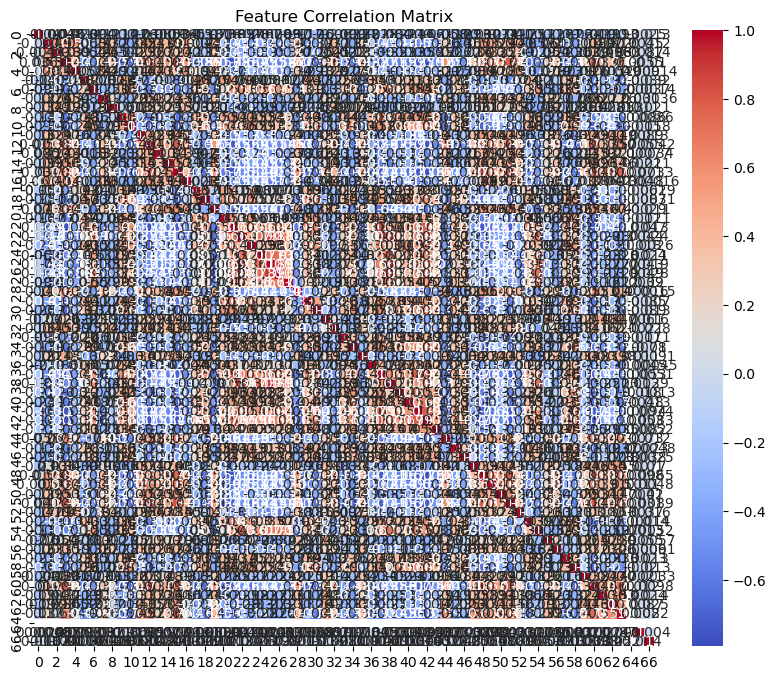

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

corr_matrix = pd.DataFrame(X_train1).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=True)
plt.title("Feature Correlation Matrix")
plt.show()


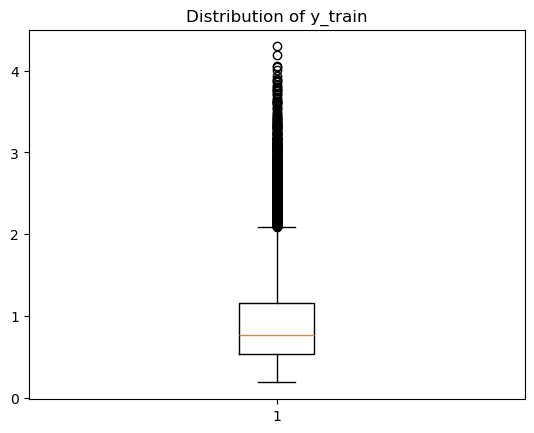

In [24]:
import matplotlib.pyplot as plt

plt.boxplot(y_train1)
plt.title("Distribution of y_train")
plt.show()


In [41]:
# Remove duplicated rows
unique_X_train, unique_indices = np.unique(X_train1, axis=0, return_index=True)
unique_y_train = y_train1[unique_indices]
X_train1, y_train1 = unique_X_train, unique_y_train


In [42]:
# Remove features with low variance
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=1e-5)  # Remove features with very low variance
X_train1 = selector.fit_transform(X_train1)
X_test1 = selector.transform(X_test1)


In [30]:
from sklearn.decomposition import PCA

pca = PCA(n_components=30)  # Reduce to 30 meaningful components
X_train1 = pca.fit_transform(X_train1)
X_test1 = pca.transform(X_test1)


In [31]:
# log transformation
y_train1 = np.log1p(y_train1)
y_test1 = np.log1p(y_test1)


In [43]:
from sklearn.tree import DecisionTreeRegressor
import pandas as pd

tree = DecisionTreeRegressor().fit(X_train1, y_train1)
importances = tree.feature_importances_

# Show top features
feature_importance_df = pd.DataFrame({"Feature": np.arange(len(importances)), "Importance": importances})
feature_importance_df = feature_importance_df.sort_values(by="Importance", ascending=False)
print(feature_importance_df.head(10))


    Feature  Importance
65       65    0.088976
3         3    0.034777
2         2    0.032988
10       10    0.031147
60       60    0.025113
23       23    0.023990
26       26    0.023983
45       45    0.022838
19       19    0.022463
58       58    0.021866


In [44]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train1, y_train1)
y_pred_rf = rf.predict(X_test1)
print(f"Random Forest R²: {r2_score(y_test1, y_pred_rf)}")


Random Forest R²: -0.0896579245392457


In [32]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression().fit(X_train1, y_train1)
y_pred_lin = lin_reg.predict(X_test1)
print("Linear Regression R²:", r2_score(y_test1, y_pred_lin))


Linear Regression R²: -5.955500385797506


In [55]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Normalize Data
scaler = StandardScaler()

# Ridge Regression with best alpha tuning
ridge = Ridge()

pipeline = Pipeline([
    ('scaler', scaler),
    ('ridge', ridge)
])

# Hyperparameter tuning
alpha_values = np.logspace(-5, 1, 100)
param_grid = {'ridge__alpha': alpha_values}

ridge_cv = GridSearchCV(pipeline, param_grid, scoring='neg_mean_squared_error', cv=5)
ridge_cv.fit(X_train1, y_train1)

best_alpha = ridge_cv.best_params_['ridge__alpha']
print(f"Best alpha: {best_alpha}")

# Train Ridge with best alpha
ridge_best = Ridge(alpha=best_alpha)
ridge_best.fit(scaler.fit_transform(X_train1), y_train1)

# Predict
y_pred = ridge_best.predict(scaler.transform(X_test1))

# Recompute MSE and R^2
mse = mean_squared_error(y_test1, y_pred)
r2 = r2_score(y_test1, y_pred)
print(f"Test MSE: {mse:.4f}")
print(f"Test R²: {r2:.4f}")


Best alpha: 10.0
Test MSE: 0.2232
Test R²: 0.0402


In [5]:
# Define Ridge Regression model
ridge = Ridge()

In [6]:
# Define hyperparameter grid
alpha_values = np.logspace(-3, 3, 100)  # Search over a range of alpha values
param_grid = {'alpha': alpha_values}

In [10]:
# Perform cross-validation on the validation set
ridge_cv = GridSearchCV(ridge, param_grid, scoring='neg_mean_squared_error', cv=5)
ridge_cv.fit(X_train1, y_train1)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': array([1.00000000e-03, 1.14975700e-03, 1.32194115e-03, 1.51991108e-03,
       1.74752840e-03, 2.00923300e-03, 2.31012970e-03, 2.65608778e-03,
       3.05385551e-03, 3.51119173e-03, 4.03701726e-03, 4.64158883e-03,
       5.33669923e-03, 6.13590727e-03, 7.05480231e-03, 8.11130831e-03,
       9.32603347e-03, 1.07226722e-02, 1.23284674e-02, 1....
       4.03701726e+01, 4.64158883e+01, 5.33669923e+01, 6.13590727e+01,
       7.05480231e+01, 8.11130831e+01, 9.32603347e+01, 1.07226722e+02,
       1.23284674e+02, 1.41747416e+02, 1.62975083e+02, 1.87381742e+02,
       2.15443469e+02, 2.47707636e+02, 2.84803587e+02, 3.27454916e+02,
       3.76493581e+02, 4.32876128e+02, 4.97702356e+02, 5.72236766e+02,
       6.57933225e+02, 7.56463328e+02, 8.69749003e+02, 1.00000000e+03])},
             scoring='neg_mean_squared_error')

In [11]:
# Best alpha found
best_alpha = ridge_cv.best_params_['alpha']
print(f"Best alpha: {best_alpha}")

Best alpha: 0.001


In [12]:
# Train final Ridge model with best alpha
ridge_best = Ridge(alpha=best_alpha)
ridge_best.fit(X_train1, y_train1)

Ridge(alpha=0.001)

In [13]:
# Predict on test set
y_pred = ridge_best.predict(X_test1)

In [15]:
# Evaluate performance
mse = mean_squared_error(y_test1, y_pred)
r2 = r2_score(y_test1, y_pred)
print(f"Test MSE: {mse:.4f}")
print(f"Test R²: {r2:.4f}")

Test MSE: 0.6995
Test R²: -5.8434


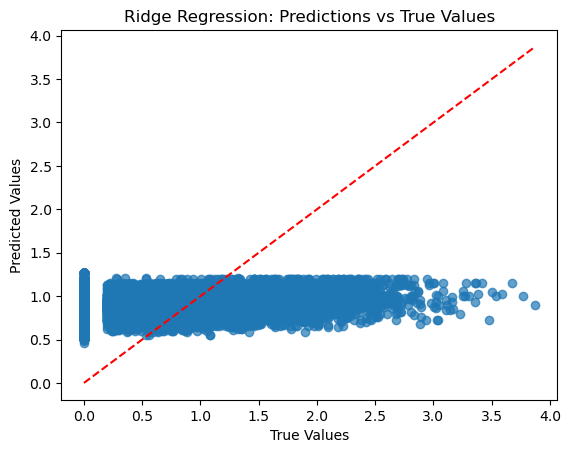

In [17]:
# Plot predictions vs true values
plt.scatter(y_test1, y_pred, alpha=0.7)
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title("Ridge Regression: Predictions vs True Values")
plt.plot([min(y_test1), max(y_test1)], [min(y_test1), max(y_test1)], color="red", linestyle="--")  # Diagonal line
plt.show()

### Before

In [31]:
# Step 2: Initialize and fit a Ridge regression model
ridge_model = Ridge(alpha=1.0)  # Regularization strength (alpha=0 means no regularization)
ridge_model.fit(X_train, y_train)

Ridge()

In [32]:
# Step 3: Make predictions
y_train_pred = ridge_model.predict(X_train)
y_test_pred = ridge_model.predict(X_test)

In [33]:
# Step 4: Evaluate the model
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

In [34]:
print(train_mse)
print(test_mse)

0.10717987920650322
0.02314573244151825


**QUESTIONS**:
- The gene expression can be different for same gene in different cells? It does not just refer to a gene_id?
- How do we know what is the end site for the embedding count, is it the gene_end?
- Is in the embedding the chromosome also important?